In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
from datetime import timedelta

dfCaudal = pd.read_excel(r'caudal.xlsx')
dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])

dfCaudal.head()

,Tempo,Caudal
0,2020-01-01 23:26:58,4.39
1,2020-01-02 00:26:58,3.9
2,2020-01-02 01:26:58,3.6
3,2020-01-02 02:26:58,3.3
4,2020-01-02 03:26:54,3.3


In [200]:
dfInterv = pd.read_excel(r'ordens.xlsx', sheet_name="Intervenções")
dfInterv.drop(dfInterv.columns[[2, 3, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18,19,20,22, 23, 24, 25]], inplace=True, axis=1)
dfInterv.rename( columns = {
    'INTERVENÇÕES': 'intervencao',
    'Unnamed: 1': 'data',
    'Unnamed: 4': 'dataexecucao',
    'Unnamed: 6': 'duracao',
    'Unnamed: 11': 'sintoma',
    'Unnamed: 21': 'zmc',
}, inplace=True)
dfInterv = dfInterv.iloc[1:, :]
dfInterv = dfInterv[dfInterv.zmc == 'ZMC de Bolho']
dfInterv['data'] = pd.to_datetime(dfInterv['data'])
dfInterv['dataexecucao'] = pd.to_datetime(dfInterv['dataexecucao'])


dfInterv.head(20)

,intervencao,data,dataexecucao,duracao,sintoma,zmc
15,IN_22_AB_03851,2022-10-07 07:45:00,2022-10-07 15:31:06,00:05:57,Abastecimento » Rede de Água » Avarias na Rede...,ZMC de Bolho
16,IN_22_AB_03850,2022-10-07 07:45:00,2022-10-07 15:12:24,03:54:14,Abastecimento » Rede de Água » Avarias na Rede...,ZMC de Bolho
64,IN_22_AB_03260,2022-08-29 07:45:00,2022-08-29 15:43:40,00:42:12,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
98,IN_22_AB_02934,2022-08-08 07:45:00,2022-08-08 16:03:02,01:07:34,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
101,IN_22_AB_02935,2022-08-04 08:00:00,2022-08-04 16:14:16,00:03:49,Abastecimento » Rede de Água » Avarias na Rede...,ZMC de Bolho
138,IN_22_AB_02550,2022-07-08 07:45:00,2022-07-08 15:47:40,01:26:10,Abastecimento » Logger's » Avaria na Rede - Lo...,ZMC de Bolho
148,IN_22_AB_02372,2022-07-01 07:45:00,2022-07-01 14:02:27,00:01:55,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
155,IN_22_AB_02280,2022-06-27 08:00:00,2022-06-27 15:57:53,00:04:00,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
166,IN_22_AB_02184,2022-06-20 11:25:14,2022-06-20 11:29:45,00:03:13,Abastecimento » Rede de Água » Avarias na Rede...,ZMC de Bolho
173,IN_22_AB_02110,2022-06-13 14:28:13,2022-06-13 14:50:39,00:13:08,Abastecimento » Rede de Água » Avarias na Rede...,ZMC de Bolho


In [233]:
def plotCaudal(timecentro, time1, time2, label):
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    cau = dfCaudal[dfCaudal['Tempo'] > time1][dfCaudal['Tempo'] < time2][dfCaudal['Caudal'] > 0]
    #interZmc.dataexecucao = interZmc.dataexecucao.hour
    #interZmc.hora = interZmc.dataexecucao.hour
    
    #plt.axvline(x = interZmc.dataexecucao, color = 'r', label=f'{interZmc.intervencao}')
    plt.scatter(x = timecentro,y=cau.Caudal.mean(), marker='X', color = 'b', label=f'Media {interZmc.intervencao}')
    plt.scatter(x = timecentro,y=cau.Caudal.std(), marker='o', color = 'r', label=f'Desvio padrao {interZmc.intervencao}')
    
    #plt.plot(dfCaudalAteExecucao.hora, dfCaudalAteExecucao.Caudal, marker='o', markevery=timeDeltaDepois, label=f'{interZmc.intervencao} {interZmc.sintoma}' )
    #plt.scatter(dfCaudalAteExecucao.hora, dfCaudalAteExecucao.Caudal, marker='X', label=f'{interZmc.intervencao} {interZmc.sintoma}' )
    plt.plot(cau.Tempo, cau.Caudal, label=label)
   


C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\1496293128.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cau = dfCaudal[dfCaudal['Tempo'] > time1][dfCaudal['Tempo'] < time2][dfCaudal['Caudal'] > 0]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\1496293128.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cau = dfCaudal[dfCaudal['Tempo'] > time1][dfCaudal['Tempo'] < time2][dfCaudal['Caudal'] > 0]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\1496293128.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cau = dfCaudal[dfCaudal['Tempo'] > time1][dfCaudal['Tempo'] < time2][dfCaudal['Caudal'] > 0]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\1496293128.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cau = dfCaudal[dfCaudal['Tempo'] > time1][dfCaudal['Tempo'] < time2][dfCaudal['Caudal'] > 0]
C:\Users\Francisco\AppData\Local

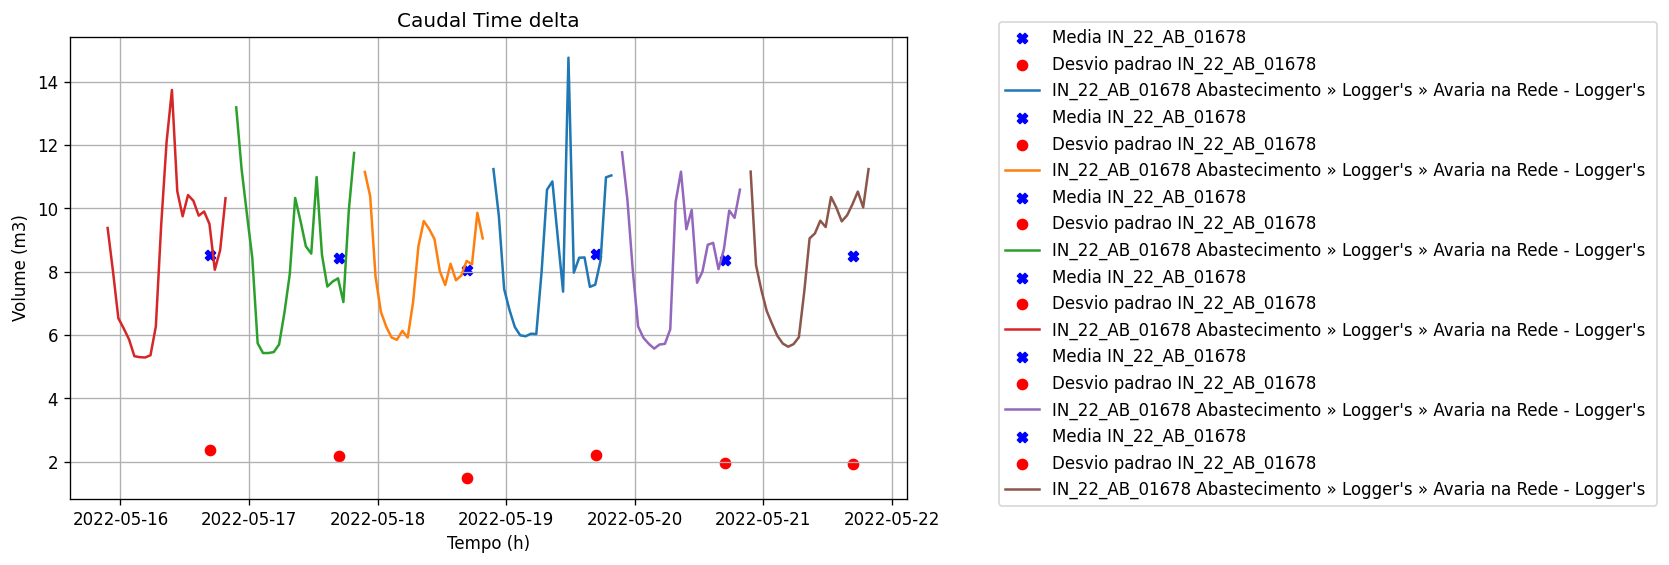

In [237]:
plt.title('Caudal Time delta')
#for i in range(0, len(dfInterv)):


def caudalInter(centro, time1, time2):
    plotCaudal(centro,time1, time2, f'{interZmc.intervencao} {interZmc.sintoma}')

def semanaDaFalha(interZmc):    
    timecentro = interZmc.dataexecucao
    caudalInter(timecentro, interZmc.dataexecucao - timedelta(hours = 20), interZmc.dataexecucao + timedelta(hours = 3))

    # dia normal 
    timecentroNormal = interZmc.dataexecucao - timedelta(days = 1)
    caudalInter(timecentroNormal,timecentroNormal - timedelta(hours = 20), timecentroNormal + timedelta(hours = 3))

    # outro dia normal 
    timecentroNormal2 = interZmc.dataexecucao - timedelta(days = 2)
    caudalInter(timecentroNormal2,timecentroNormal2 - timedelta(hours = 20), timecentroNormal2 + timedelta(hours = 3))

    # outro dia normal 
    timecentroNormal3 = interZmc.dataexecucao - timedelta(days = 3)
    caudalInter(timecentroNormal3,timecentroNormal3 - timedelta(hours = 20), timecentroNormal3 + timedelta(hours = 3))


    # outro dia normal 
    timecentroNormal4 = interZmc.dataexecucao + timedelta(days = 1)
    caudalInter(timecentroNormal4,timecentroNormal4 - timedelta(hours = 20), timecentroNormal4 + timedelta(hours = 3))

    # outro dia normal 
    timecentroNormal5 = interZmc.dataexecucao + timedelta(days = 2)
    caudalInter(timecentroNormal5,timecentroNormal5 - timedelta(hours = 20), timecentroNormal5 + timedelta(hours = 3))

semanaDaFalha(dfInterv.iloc[len(dfInterv) - 2])
#  
leg = plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('Volume (m3)')
plt.xlabel('Tempo (h)')
plt.grid(True)



In [7]:
variacaoSemanal= dfCaudal.copy()
variacaoSemanal['weekday'] = variacaoSemanal.Tempo.dt.weekday
variacaoSemanal = variacaoSemanal.groupby('weekday').agg({'Caudal':'mean'})
variacaoSemanal.head(10)

,Caudal
weekday,
0,7.178528
1,7.139487
2,7.225430
3,7.156533
4,7.824878
5,8.274434
6,7.608919


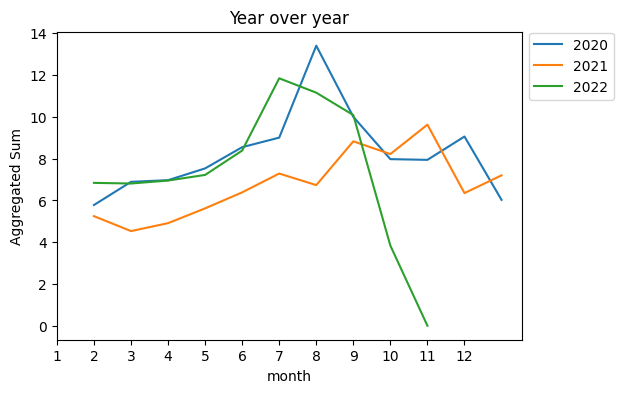

In [8]:
variacaoAnual= dfCaudal.copy()
variacaoAnual['year'] = dfCaudal.Tempo.dt.year
variacaoAnual['month'] = dfCaudal.Tempo.dt.month
variacaoAnual.set_index(["year","month"], inplace = True)

dfp = pd.pivot_table(data=variacaoAnual, index='month', columns='year', values='Caudal', aggfunc='mean')

ax = dfp.plot(ylabel='Aggregated Sum', figsize=(6, 4))
ax.set_title('Year over year')
ax.set_xticks(range(12)) # set ticks for all months
ax.set_xticklabels(dfp.index) # label all the ticks
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

<AxesSubplot: xlabel='year', ylabel='Caudal'>

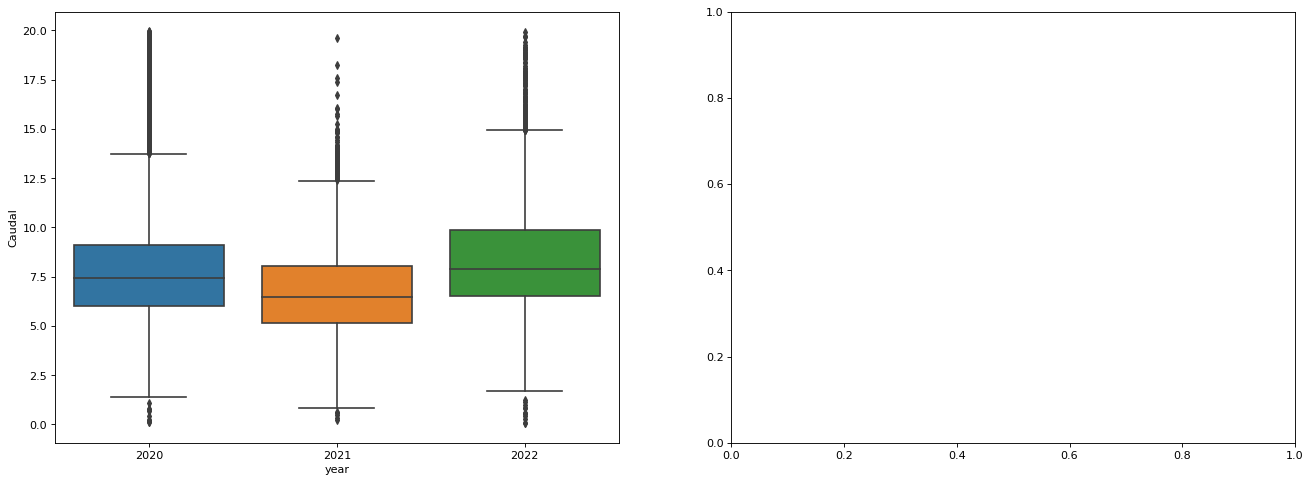

In [9]:


variacaBoxPlot = dfCaudal.copy()
variacaBoxPlot['year'] = dfCaudal.Tempo.dt.year
variacaBoxPlot['month'] = dfCaudal.Tempo.dt.month
#variacaBoxPlot.set_index(["year","month"], inplace = True)

colindex = 1
colname = variacaBoxPlot.columns[colindex]

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
#sns.boxplot(x='year', y='value', data=df, ax=axes[0])
variacaBoxPlot = variacaBoxPlot[variacaBoxPlot.Caudal < 20]
variacaBoxPlot = variacaBoxPlot[variacaBoxPlot.Caudal > 0]
sns.boxplot(x='year', y=colname, data =variacaBoxPlot, ax=axes[0])

C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\4228564964.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = dfCaudal.copy()[dfCaudal['Caudal'] > 0][dfCaudal['Caudal'] < 20][24*2:24*6] # Get part of the lines in the dataframe


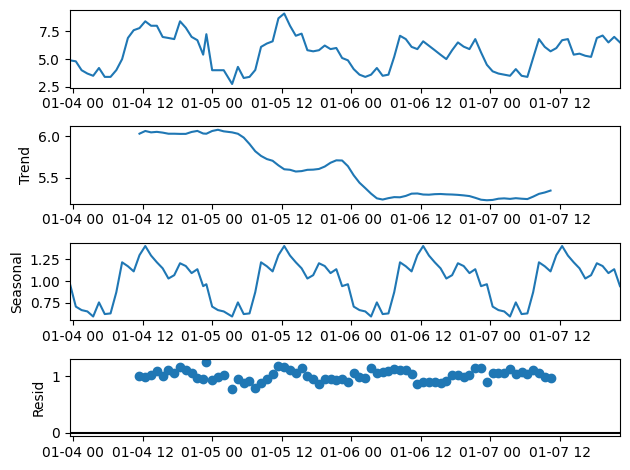

In [64]:
# seasonal decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

df1 = dfCaudal.copy()[dfCaudal['Caudal'] > 0][dfCaudal['Caudal'] < 20][24*2:24*6] # Get part of the lines in the dataframe
df1.set_index('Tempo', inplace=True)
df2 = df1[['Caudal']].copy()
decompose_result_mult = seasonal_decompose(df2,
 model="multiplicative", period=24)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

In [67]:
from pandas import Series
series = Series(dfCaudal['Caudal'])
series.describe()

count    24060.000000
mean         7.488471
std         10.519923
min        -75.740000
25%          5.430000
50%          7.100000
75%          8.800000
max       1434.430000
Name: Caudal, dtype: float64

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

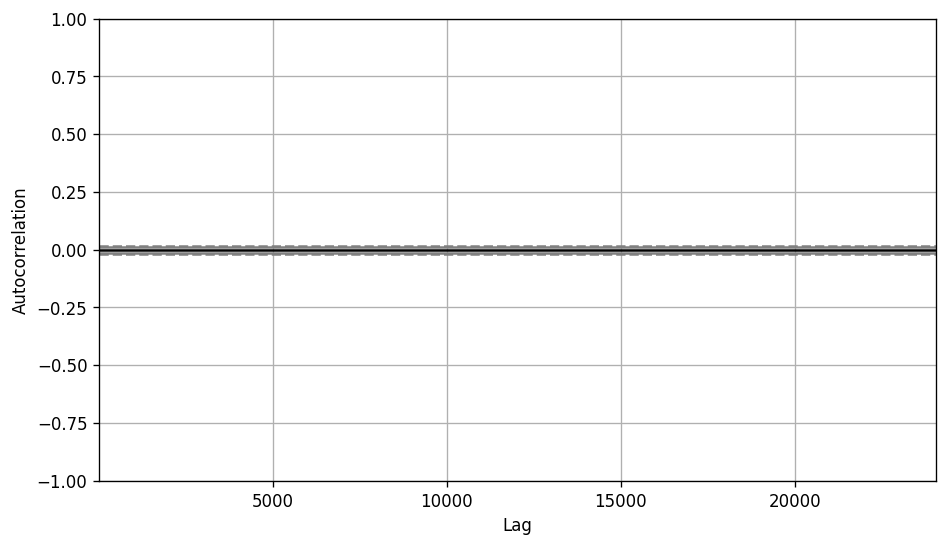

In [148]:
from pandas.plotting import autocorrelation_plot
# TODO ver o significado deste
plt.rcParams.update({'figure.figsize':(9,5),
'figure.dpi':120})
autocorrelation_plot(series)

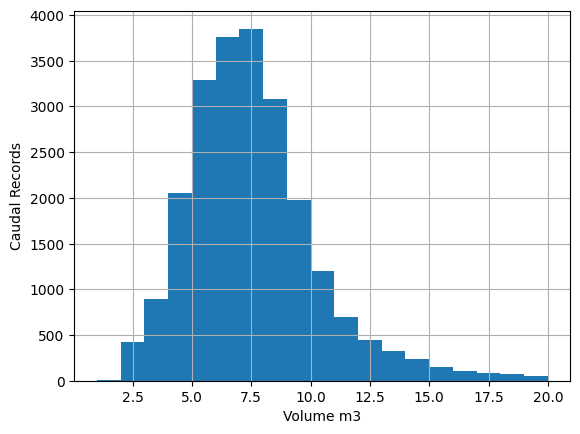

In [88]:
# separar em anos pode ajudar

#caudal total
series.hist(bins=list(range(1,20+1)))
plt.xlabel('Volume m3')
plt.ylabel("Caudal Records");

In [141]:
def seasonalByInter(intervencaoSelecionada, timeFrame):
    print(intervencaoSelecionada.dataexecucao)
    intervencao = dfCaudal.copy()[dfCaudal['Tempo'] > intervencaoSelecionada.dataexecucao - timedelta(hours = timeFrame)][dfCaudal['Tempo'] < intervencaoSelecionada.dataexecucao + timedelta(hours = timeFrame)]
    intervencao.set_index('Tempo', inplace=True)
    caudalIntervencao = intervencao[['Caudal']][.copy()
    caudal_decompose_result_mult = seasonal_decompose(caudalIntervencao,
    model="multiplicative", period = 24)
    caudal_trend = caudal_decompose_result_mult.trend
    caudal_seasonal = caudal_decompose_result_mult.seasonal
    caudal_residual = caudal_decompose_result_mult.resid
    caudal_decompose_result_mult.plot();
    

In [165]:
from pandas.plotting import lag_plot
# ver como este pode ajudar 
def lagPlot():
    dfCaudal[['Ca']]
    #plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
    #ig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    #for i, ax in enumerate(axes.flatten()[:4]):
    # lag_plot(df2, lag=i+1, ax=ax, c='firebrick')
    #ax.set_title('Lag ' + str(i+1))

In [191]:
from statsmodels.tsa.stattools import adfuller, kpss

def testeEstacionaridade():
    caudal = dfCaudal.copy()[['Caudal']][dfCaudal['Caudal'] > 0]
    result = adfuller(caudal, autolag='AIC') # choose number of lags to minimize criterion
    print(f'ADF Statistic test: {result[0]}')
    print(f'p-value: {result[1]}')
    if(result[1] < 0.05):
        print(f'Estacionaria: SIM')
    else:
        print(f'Estacionaria: NAO')
        
    for key, value in result[4].items(): # Critical values at 1, 5, 10 %
        print('Critial Values:')
        print(f' {key}, {value}')
testeEstacionaridade()

ADF Statistic test: -15.49675211599353
p-value: 2.444898068451461e-28
Estacionaria: SIM
Critial Values:
 1%, -3.430635903124197
Critial Values:
 5%, -2.861666360007406
Critial Values:
 10%, -2.5668372578272267
